In [ ]:
import numpy as np
import pandas as pd

from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

#from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error


from ExploreData import sort_mean, value_counter, index_by_key
from TransformData import \
    price_transform, rate_transform, split_column_values, date_transform

import CategoricalPrep as cp
import PrepAndModel as pam
import FeatureEngine as fe

In [ ]:
df_listings = pd.read_csv('./data/listings.csv')

In [ ]:
# Drop Columns without information
listings_drop_col = cp.drop_columns_analyze(df_listings)
# Transform categorical columns and make information accessable
listings_drop_trans = cp.transform_columns(listings_drop_col)
# Create new price features
listings_features = fe.new_features(listings_drop_trans)
# Encode or drop the remaining categorical columns
listings_encode = pam.feature_encoding(listings_features)
# Impute missing values
listings_impute = pam.imputation(listings_encode)


# The Host Perspective

The data set has been fully prepared for a machine learning algorithm with the functions above summarizing the neccessary actions from previous netebooks.

Some preparations had already been done before we analysed questions one and two in notebook 02. But these were only meant to make the information better accessable and not to prepare for machine learning. That is why we deal with the rest using the functions *feature_encoding* and *imputation* in the cell above.

Now we deal with question three.

## Can we make a good price estimation for a new offer to assist a (new) host?

The data-set holds some information which is usually not available for a new offer. For example reviews, or review scores. Function *drop_too_much_information* deals with that and simply drops these features from the data-set.

Below are some more functions inteded to train a model and score it:


In [ ]:
def drop_too_much_information(df):
    ''' Drops information unsuited for the scenario '''

    unknown_features = index_by_key(df, ['availability', 'review'])
    df = df.drop(columns=unknown_features, axis=1)
    return df

def split_xy(df, flag_name):
    ''' Seperates the flag from the data set '''

    # Split into explanatory and response variables
    X = df.drop(axis=1, columns=[flag_name])
    y = df[flag_name]
    return X, y

def train_score_tree(df, flag_name, test_ratio, seed, model):
    '''
    * Seperates the result 'flag_mane' form the data-set 'df',
    * splits into training and test data with 'test_ratio' and 'seed',
    * trains a ml-model 'model',
    * predicts results 'y_test_pred' and 
        'y_rain_pred' for test and training data,
    * and scores both predictions.

    INPUT:
        df (pd.DataFrame):
        flag_name (str):
        test_ratio (float):
        seed (float):
        model:

    OUTPUT:
        X_train
        X_test
        y_train
        y_test
        y_train_pred
        y_test_pred
        train_score
        test_score
    '''

    # Split into explanatory and response variables
    X, y = split_xy(df, flag_name) 
    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_ratio, random_state=seed)
    # Train
    model.fit(X_train, y_train)
    # Predict and score the model
    y_test_pred = model.predict(X_test) 
    y_train_pred = model.predict(X_train)
    test_score = r2_score(y_test, y_test_pred)
    train_score = r2_score(y_train, y_train_pred)

    return X_train, X_test, y_train, y_test, y_train_pred, y_test_pred, train_score, test_score

In [ ]:
df = listings_impute
# Remove information unknown about a new listing
df = drop_too_much_information(df)

### Train and Score a Decision Tree Regressor

In [55]:
# Instanciate a model
ml_tree = DecisionTreeRegressor(random_state=112358)
# Train and score it
X_train, X_test, y_train, y_test, y_train_pred, y_test_pred, train_score, test_score = train_score_tree(
    df, 'price', 0.2, 43, ml_tree)

print( 'Score at training: ', train_score ,'\nScore at test: ', test_score)

Score at training:  1.0 
Score at test:  0.965596566631295


### Cross Validation and Grid Search Cross Validation

In [56]:
X, y = split_xy(df, 'price') 
# Ten fold cross validation (r2_score ist the default estimator)
cv_tree = cross_val_score(ml_tree, X, y, cv=10)
cv_tree

array([0.96327603, 0.99789295, 0.86676132, 0.88765299, 0.99649381,
       0.99442832, 0.96144508, 0.98623376, 0.95898948, 0.99131221])

In [ ]:
# Optimize hyper parameters

# Set a range of hyper parameters for a grid search
par_tree = {'criterion': ['mse', 'mae'],
    'min_samples_split': [ 10, 20, 40],
    'max_depth': [2, 6, 8],
    'min_samples_leaf': [ 20, 40, 100],
    'max_leaf_nodes': [5, 20, 100]
    }

# Instanciate a GridSearchCV for 'ml_tree'
gridsearch_tree = GridSearchCV(ml_tree, par_tree, cv=10)
# Perform the grid search on the training data (this takes a while!)
gridsearch_tree.fit(X_train, y_train)

# Load gscv results to DataFrames
df_cv_tree = pd.DataFrame(gridsearch_tree.cv_results_)
df_best_param = pd.DataFrame(gridsearch_tree.best_params_, index=[0])
# Save results to csv
df_cv_tree.to_csv('grid_search_parameter_results.csv')
df_best_param.to_csv('grid_search_best_parameter.csv')

print('Best score:{}'.format(gridsearch_tree.best_score_))
print('Best Parameter:{}'.format(gridsearch_tree.best_params_))
# Score:0.906381437648208
# Parameter:{'criterion': 'mse', 'max_depth': 8, 'max_leaf_nodes': 100, 'min_samples_leaf': 20, 'min_samples_split': 10}
# Best score:0.935253279596466
# Best Parameter:{'criterion': 'mse', 'max_depth': 15, 'max_leaf_nodes': 180, 'min_samples_leaf': 10, 'min_samples_split': 5}

In [ ]:
# Load reasults from csv to df
df_cv_tree = pd.read_csv('grid_search_parameter_results.csv')
df_best_param = pd.read_csv('grid_search_best_parameter.csv')

### Plotting Grid Search Results

In [ ]:
def plot_gs_param(df_cv, best_parameters, parameter, ax, color):
    ''' Plots one GridSearch hyper-parameter against 'mean_test_score'

    INPUT:
        df_cv (pd.DataFrame): GridSearchCV.cv_results_
        best_paramters (pd.Series) - GridSearchCV.best_params_
            or 'df_cv' column with 'best mean_test_score'
            index should match 'df_cv' column names
        parameter (str): 'the param_'-column in 'df_cv' to plot
        ax (plt.ax): the ax to plot in
        color (str): the plot color
    '''

    df = df_cv
    # drop the paramter from the 'best_parameter' list to keep all values
    best_parameters = best_parameters.drop(parameter)
    best_index = best_parameters.index
    # Loop through 'best_index' and filter each column for the best value
    for i in best_index:
        df = df.loc[df[i] == best_parameters[i]]
    df.plot(kind='scatter', x='mean_test_score',
            y=parameter, s=100, ax=ax, color=color)
    return


In [ ]:
# Select parameter columns
parameter_cols = index_by_key(df_cv_tree, ['param_'])
# Turn 'df_best_param' into a pd.Series
best = df_best_param.rename(lambda x: 'param_'+x , axis=1).squeeze()
best = best[parameter_cols]

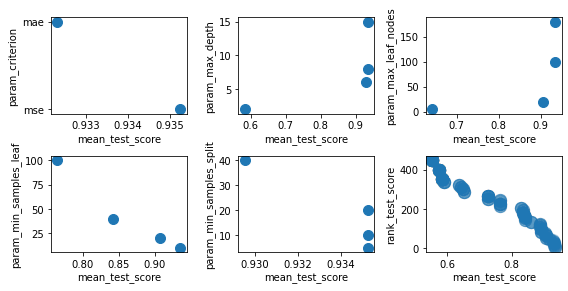

In [58]:
# Create a figure and axes
f, ax = plt.subplots(2, 3, figsize=[8,4])
ax = list(ax[0,:])+list(ax[1,:])

# Plot all paremeters against mean_test_score
for i in range(0,parameter_cols.shape[0]):
    plot_gs_param(df_cv_tree, best, parameter_cols[i], ax[i], 'C0')

# Plot the developement for GridSearchCV
df_cv_tree.plot(kind='scatter', x='mean_test_score', y='rank_test_score', s=150, alpha=0.1, ax=ax[5])
f.tight_layout()